In [1]:
import sys
import pickle
from scipy import signal
from scipy import stats
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import cohen_kappa_score

import math
from collections import OrderedDict


import matplotlib.pyplot as plt

sys.path.append('D:\Diamond\code')
from csp_james_2 import *

sys.path.append('D:\Diamond\code')
from thesis_funcs_19_03 import *

import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler

import csv
from random import randint
import random
import datetime
import scipy

In [2]:
save_root  = 'E:\\Diamond\\own_expo\\pilot_test\\'
config_root= 'E:\\Diamond\\bci_iv\\MODELS\\fbcsp_mibif_cnn\\2a\\configs\\'


k_fold = 5


# initialize csp
m = 2# m is Nw in the paper "learning temporal information for brain-copmuter interface, Sakhavi et.al"
n_components = 2 * m  # pick some components
down_sample_step = 10 #Hilbert evelope
# select Ns pairs of csp filters
Ns = 4

CLASSES =[0,1]

C_OVR = [0,1]

balance_classes = 1


########################################################################################################################
                                            # DEFINE FILTER BANK
########################################################################################################################
#Filter Bank
FB = [[4., 8.], [8., 12.], [12., 16.], [16., 20.], [20., 24.], [24., 28.], [28., 32.], [32., 36.], [36., 40.]]
FB = np.array(FB)

#argumaents for Chebyl II filtering
# Nyquist frequency

# min. attenuation in stop band
gstop = 45
# max. attenuation in passband
gpass= 5 


#EEG_PERIOD = [[1,2.5]]#actual MI eeg period, from 0.5s after cue to end of MI at 4 seconds after cue onset
FS = [512]


to_center_matrix = 0
calc_kl_d = 0
calc_mi_discrim  =0

In [3]:
# read _lambda values
with open(config_root +'_lambda_config.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for row in csv_reader:
        _lambda_list_str = row[1:]
csv_file.close()        

#create _lambda value in list
_lambda_list = []
for i in _lambda_list_str:
    _lambda_list.append(float(i))

# Make features using trained CSP (4s MI eeg) applied to 1s and 2s MI eegs


In [4]:
to_save = 1

Signal_lens = ['05_15', '10_20', '15_25', '20_30', '25_35', '30_40'] + ['05_25', '10_30', '15_35', '20_40']


portion = 1
portion_train = str(int(portion*100)) #mistake carried over - cv_train is actually the portion of training data used, and the directory name
cv_train_size = 0.5 #cv_train_size if the actually cv split



for subject in range(3,4):
    sub_id = 's' + str(subject)
    print (subject)

    for signal_len in Signal_lens:
        
        file_root  = save_root + sub_id + '\\models\\carryover_4s_csp\\' + signal_len + '\\'
        k_file_root = file_root + 'pt_'+ portion_train + '\\'

        
        #eeg_period = EEG_PERIOD[0]
        eeg_period = signal_len_to_eeg_period(signal_len)
        
        
        fs = FS[0]

        """
        #set load_idx to 0 if we want to create new and overwirite old T_IND files
        COVS_AL_FD,  EEG_filt_FB_go, LABELS0_go, TRAIN_IDX, TEST_IDX, Train_idx = calc_k_covs_all_fold_current(filename_T, raw_data_root, 
                                                                                                                portion, k_file_root, 
                                                                                                                balance_classes, 
                                                                                                       FB,  gpass, gstop, fs, eeg_period, 
                                                                                                       k_fold, C_OVR, load_idx = 0, 
                                                                                                       cv_train_size = cv_train_size, 
                                                                                                     to_center_matrix = to_center_matrix)
        """

        ## LOAD in raw EEG(MI) portion and LABELS
        EEG_MI_RAW_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + ".pickle", "rb" ) )
        LABELS_load = pickle.load(open( 'E:\\Diamond\\own_expo\\pilot_test\\' + sub_id + '\\signals\\' + sub_id + "_LABELS.pickle", "rb" ) )
        #seperate the raw EEG into training and evaluaiton sets
        EEG_MI_RAW_T, LABELS_load_T, EEG_MI_RAW_E, LABELS_load_E= seperate_train_eval_ind(EEG_MI_RAW_load, LABELS_load)
        LABELS = LABELS_load_T - 1

        COVS_AL_FD,  EEG_filt_FB_go, LABELS0_go, TRAIN_IDX, TEST_IDX, Train_idx = calc_k_covs_all_fold_own_expo(EEG_MI_RAW_T, LABELS, 
                                                                                                        portion, k_file_root, balance_classes, FB, gpass, gstop, 
                                                                                                        fs, [0,4.5], 
                                                                                                       k_fold, C_OVR, load_idx = 0, 
                                                                                                       cv_train_size = cv_train_size, 
                                                                                                     to_center_matrix = to_center_matrix)


        if to_save == 1:
            pickle.dump(TRAIN_IDX , open(file_root +'pt_'+ portion_train + '\\TRAIN_IDX' + ".pickle", "wb" ) )

            pickle.dump(TEST_IDX , open(file_root +'pt_'+ portion_train + '\\TEST_IDX' + ".pickle", "wb" ) )

            pickle.dump(LABELS0_go , open(file_root +'pt_'+ portion_train + '\\LABELS0_go' + ".pickle", "wb" ) )

        for fold in range (0, k_fold):
            Covs_k = COVS_AL_FD[fold] #9 4 2 22 22 
            for _lambda in _lambda_list[0:1]:
                for c_ovr in C_OVR:

                    W_B = []
                    for i in range (0, len(FB)):
                        W_B.append([])


                    train_idx = Train_idx[fold][c_ovr]
                    EEG_train = EEG_filt_FB_go[:, train_idx, :]    
                    LABELS_train = LABELS0_go[train_idx]
                    LABELS_train = make_ovr_01_labels(LABELS_train, c_ovr)

                    V= [] 
                    for tr in range (0, len(train_idx)):
                        V.append([])


                    for fb in range (0, len(FB)):


                        C_ck = (1-_lambda)*Covs_k[fb, c_ovr] #+ _lambda*sec_term 

                        eigen_vectors_sorted, eigen_values = calc_sort_eigenvectors(C_ck)
                        W_b_ = np.concatenate ( [eigen_vectors_sorted[:, 0:int(m)],  eigen_vectors_sorted[:, -int(m):]], axis = 1)
                        W_B[fb].append(W_b_)



                        for tr in range (0, len(train_idx)):
                            eeg = EEG_train[fb, tr, :]

                            #calculate features
                            v_bi = csp_features(W_b_, m, eeg)

                            #contruct feature matrix
                            V[tr].append(v_bi)

                    V = np.array(V)
                    V = V.reshape([np.shape(V)[0], np.shape(V)[1]*np.shape(V)[2]]) 
                    W_B = np.array(W_B).squeeze()

                    #follow MIBIF Algorithm in bci_iv_fbcsp paper
                    F = np.transpose(V)  

                    ####CALCULATE MUTUAL INFORMATION FOR THE FEATURES
                    I_fj = calc_MI(FB, m, CLASSES, LABELS_train, F)

                    ####SORT FEATURES ACCORDING TO MUTAUL INFORMATION
                    # I_fj_sorted is the indices of features ranked by decending mutal information, in shape (num_features, );
                    #where num_features = 2* m * num_FB
                    I_fj_sorted = np.argsort(I_fj)[::-1]


                    #the filter bank indices from which the features come from, in shape (num_features, )
                    FB_IND = np.floor(I_fj_sorted/(2*m)).astype(int)
                    #the filter channel (csp.eigen_vectors_sorted column) indiceis from which the features come from, in shape (num_features, )
                    FILTER_IND = (I_fj_sorted) - FB_IND * (2*m)

                    #combine the filterbank indicies and the CSP filter indicies, 
                    #first column tells which filter bank the feature came from, 
                    #second column tells which csp filter channel the feature came from
                    FB_FILTER_IND = np.array(list(zip(FB_IND, FILTER_IND)))

                    if to_save == 1:
                        pickle.dump( W_B, open(file_root + 'pt_' + portion_train
                                                        + '\\W_B_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) +
                                               ".pickle", "wb" ) )

                        pickle.dump( FB_FILTER_IND, open(file_root + 'pt_' + portion_train + '\\FB_FILTER_IND_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) +
                                               ".pickle", "wb" ) )


         ########################################################################################################################

        for fold in range (0, k_fold):
            #print ('fold', fold)
            for _lambda in _lambda_list[0:1]:
                for c_ovr in C_OVR:
                    #print (c_ovr)


                    #load in csp filters and mutual informtaion ranked indicies
                    W_B = pickle.load(open( file_root + 'pt_' + portion_train
                                                        + '\\W_B_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) + 
                                               ".pickle", 'rb'))


                    FB_FILTER_IND = pickle.load(open( file_root + 'pt_' + portion_train
                                                        + '\\FB_FILTER_IND_fold_' + str(fold) + 
                                               '_c_ovr_' + str(c_ovr) + '_lambda_' + str(_lambda) + 
                                               ".pickle", 'rb'))




                    #find the selected csp filters indicies
                    FB_FILTER_IND_slt = find_selected_csp_filters(Ns, m, FB_FILTER_IND)

                    #construct selected csp filters, W_B_slt has shape (2*Ns, num_chls), (8,22) for example
                    W_B_slt = W_B[FB_FILTER_IND_slt[:,0], :, FB_FILTER_IND_slt[:,1]]



                    #load in training eeg signals and testing EEG
                    train_idx = TRAIN_IDX[fold]
                    test_idx = TEST_IDX[fold]
                    EEG_train_FB = EEG_filt_FB_go[:,train_idx,:, int(eeg_period[0]*fs):int(eeg_period[1]*fs)]
                    EEG_test_FB = EEG_filt_FB_go[:,test_idx,:, int(eeg_period[0]*fs):int(eeg_period[1]*fs)]
                    #pick only the eeg signals filtered by selected filter banks
                    EEG_train_FB_slt = EEG_train_FB[FB_FILTER_IND_slt[:,0], :]
                    EEG_test_FB_slt = EEG_test_FB[FB_FILTER_IND_slt[:,0], :]

                    #transform into z space, then take the hilbert envelope of the transformed signal
                    Z_env_train = calc_z_features(W_B_slt, EEG_train_FB_slt, Ns, down_sample_step)
                    Z_env_test = calc_z_features(W_B_slt, EEG_test_FB_slt, Ns, down_sample_step)

                    #concatenate all classes
                    if c_ovr == C_OVR[0]:
                        Z_all_classes_train = Z_env_train
                        Z_all_classes_test = Z_env_test
                    else:
                        Z_all_classes_train = np.concatenate((Z_all_classes_train, Z_env_train), axis = 0)
                        Z_all_classes_test = np.concatenate((Z_all_classes_test, Z_env_test), axis = 0)


                #trasnpose into shape (num_trials, num_features, sample points)
                Z_all_classes_train = np.transpose(Z_all_classes_train, [1,0,2])
                Z_all_classes_test = np.transpose(Z_all_classes_test, [1,0,2])

                #save the Z space hilbert envelop signals
                if to_save == 1:
                    pickle.dump( Z_all_classes_train, open(file_root +'pt_' + portion_train
                                                        + '\\Z_all_classes_train_fold_' + str(fold) + '_lambda_' + str(_lambda) + ".pickle", "wb" ) )

                    pickle.dump( Z_all_classes_test, open(file_root +'pt_' + portion_train
                                                        + '\\Z_all_classes_test_fold_' + str(fold) + '_lambda_' + str(_lambda) + ".pickle", "wb" ) )


    

3


D:\THINKPAD\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
D:\THINKPAD\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1593: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


In [32]:
eeg_period

[2.0, 4.0]

In [27]:
np.shape(EEG_filt_FB_go)

(9, 60, 16, 512)

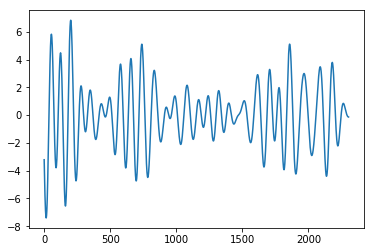

In [7]:
plt.plot(EEG_filt_FB_go[0][0][0])

In [11]:
np.shape(EEG_train_FB)

(9, 30, 16, 1024)

In [12]:
1024/512

2.0